In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd

import pandas as pd

from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily

import dask.bag as db
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from tqdm.auto import tqdm
from dask.distributed import LocalCluster, Client
import dask.bag as db
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from tqdm.auto import tqdm
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import pandas as pd
from glob import glob


/ext3/miniconda3/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [14]:
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    cluster = LocalCluster(n_workers=7, threads_per_worker=2, memory_limit='8GB')  # Increase memory per worker
    client = Client(cluster, timeout="600")
else:
    cluster = SLURMCluster(
        memory='30GB', cores=30,  # Increase memory per worker
        python='/scratch/work/public/dask/{}/bin/python'.format(dask.__version__),
        job_extra=['--output=/scratch/{}/slurm-%j.out --export=NONE'.format(os.environ['SLURM_JOB_USER'])]
    )
    
    cluster.submit_command = 'slurm'
    cluster.scale(100)
    client = Client(cluster,timeout = "600")


display(client)


/ext3/miniconda3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37169 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/scratch/jw5487/Untitled Folder/dask-worker-space/worker-upapth3m', purging
distributed.diskutils - INFO - Found stale lock file and directory '/scratch/jw5487/Untitled Folder/dask-worker-space/worker-8e6e0ymm', purging
distributed.diskutils - INFO - Found stale lock file and directory '/scratch/jw5487/Untitled Folder/dask-worker-space/worker-gv6y88jw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/scratch/jw5487/Untitled Folder/dask-worker-space/worker-88p8vyly', purging
distributed.diskutils - INFO - Found stale lock file and directory '/scratch/jw5487/Untitled Folder/dask-worker-space/worker-974kol88', purging
distributed.diskutils - INFO - Found stale lock file and dire

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37169/status,
Dashboard: http://127.0.0.1:37169/status,Workers: 7
Total threads: 14,Total memory: 52.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34329,Workers: 7
Dashboard: http://127.0.0.1:37169/status,Total threads: 14
Started: Just now,Total memory: 52.15 GiB
Comm: tcp://127.0.0.1:34197,Total threads: 2
Dashboard: http://127.0.0.1:44409/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:32787,


In [3]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
#files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

# Load in a single file to demonstrate the parser
# Just print out the first few recordsto illustrate the structure
load_daily(files[0])[:3]


[{'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 1,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'},
 {'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 2,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'},
 {'station_id': 'ASN00002069',
  'year': 1993,
  'month': 7,
  'element': 'PRCP',
  'day': 3,
  'value': 0,
  'measurement': ' ',
  'quality': ' ',
  'source': 'a'}]

In [12]:
import dask.bag as db

# Define a function to filter out invalid days
def filter_invalid_days(record):
    return record['value'] != -9999 and record['quality'] == ' '

# Create Dask Bag from the list of files
bag = db.from_sequence(files).map(load_daily).flatten()

# Filter out invalid days
valid_records = bag.filter(filter_invalid_days)


In [15]:
import dask.dataframe as dd

# Convert Dask Bag to Dask DataFrame
df = valid_records.to_dataframe()

# Keep only TMAX and TMIN records
df = df[df['element'].isin(['TMAX', 'TMIN'])]

# Group by station_id, year, month, day, and element
grouped_df = df.groupby(['station_id', 'year', 'month', 'day', 'element'])['value'].first().reset_index()

# Split the DataFrame into TMAX and TMIN DataFrames
tmax_df = grouped_df[grouped_df['element'] == 'TMAX']
tmin_df = grouped_df[grouped_df['element'] == 'TMIN']

# Merge TMAX and TMIN DataFrames on ['station_id', 'year', 'month', 'day']
merged_df = tmax_df.merge(tmin_df, on=['station_id', 'year', 'month', 'day'], suffixes=('_TMAX', '_TMIN'))

# Calculate the temperature range
merged_df['t_range'] = merged_df['value_TMAX'] - merged_df['value_TMIN']

# Group by station_id and find the maximum temperature range
result = merged_df.groupby('station_id')['t_range'].max()

# Compute and display the result as a Pandas DataFrame
result.compute()


/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():


station_id
ASN00063226    274
CA002402688    272
CA004012040    339
MXN00018074    222
MXN00026133    311
MXN00031086    350
RMC00914399    122
USC00046773    317
USC00180565    239
USC00295691    372
Name: t_range, dtype: int64

/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():
/ext3/miniconda3/lib/python3.9/site-packages/dask/sizeof.py:151: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, col in df.iteritems():


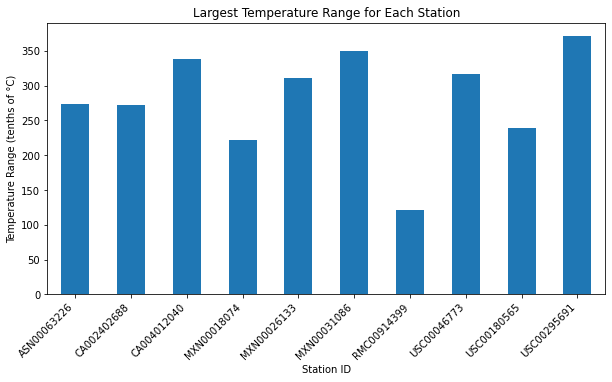

In [16]:
import matplotlib.pyplot as plt

# Convert the result Dask DataFrame to a Pandas DataFrame
result_pd = result.compute()

# Create a bar plot of the largest temperature range for each station
fig, ax = plt.subplots(figsize=(10, 5))
result_pd.plot(kind='bar', ax=ax)
ax.set_ylabel('Temperature Range (tenths of °C)')
ax.set_xlabel('Station ID')
ax.set_title('Largest Temperature Range for Each Station')

# Rotate the x-axis labels to improve readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [5]:
def process_partition(part):
    part = part[part['element'].isin(['TMAX', 'TMIN'])]
    return part.groupby(['station_id', 'year', 'month', 'day', 'element'], as_index=False)['value'].mean()


def process_files_chunk(files_chunk):
    bag = db.from_sequence(files_chunk).map(load_daily).flatten()
    valid_records = bag.filter(filter_invalid_days)
    df = valid_records.to_dataframe()
    grouped_df = df.map_partitions(process_partition).compute()

    tmax_df = grouped_df[grouped_df['element'] == 'TMAX']
    tmin_df = grouped_df[grouped_df['element'] == 'TMIN']

    merged_df = tmax_df.merge(tmin_df, on=['station_id', 'year', 'month', 'day'], suffixes=('_TMAX', '_TMIN'))
    merged_df['t_range'] = merged_df['value_TMAX'] - merged_df['value_TMIN']

    result = merged_df.groupby('station_id')['t_range'].max()

    return dd.from_pandas(result, npartitions=1)

def process_and_save_data(input_path, output_file):
    files = sorted(glob(input_path + '/*.dly'))

    # Optimize the chunk size based on your cluster's configuration
    chunk_size = 50

    results = []

    for i in tqdm(range(0, len(files), chunk_size)):
        files_chunk = files[i:i + chunk_size]
        result_chunk = process_files_chunk(files_chunk)
        # Convert the Dask Series to a Dask DataFrame with a single column
        result_chunk_df = result_chunk.to_frame()
        results.append(result_chunk_df)

    # Concatenate the list of Dask DataFrames
    combined_results = dd.concat(results, interleave_partitions=True)

    # Repartition the Dask DataFrame
    combined_results = combined_results.repartition(npartitions=100)

    # Perform the groupby operation on the concatenated Dask DataFrame
    max_combined_results = combined_results.groupby('station_id').max()

    with ProgressBar():
        final_result = max_combined_results.compute()
        final_result_df = final_result  # Convert the Series to a DataFrame
        final_result_df.to_parquet(output_file)


In [6]:
%time process_and_save_data('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny', 'tdiff-tiny-complete.parquet')


  0%|          | 0/1 [00:00<?, ?it/s]

/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  return self.map_partitions(M.to_frame, name, meta=self._meta.to_frame(name))


CPU times: user 438 ms, sys: 108 ms, total: 546 ms
Wall time: 1.93 s


In [8]:
%time process_and_save_data('/scratch/work/courses/DSGA1004-2021/ghcnd_small', 'tdiff-small-complete.parquet')


  0%|          | 0/20 [00:00<?, ?it/s]

/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  return self.map_partitions(M.to_frame, name, meta=self._meta.to_frame(name))
/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  return self.map_partitions(M.to_frame, name, meta=self._meta.to_frame(name))
/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None`

CPU times: user 7.4 s, sys: 1.11 s, total: 8.51 s
Wall time: 17.5 s


In [11]:
%time process_and_save_data('/scratch/work/courses/DSGA1004-2021/ghcnd_all', 'tdiff-all-complete.parquet')

  0%|          | 0/2370 [00:00<?, ?it/s]

/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  return self.map_partitions(M.to_frame, name, meta=self._meta.to_frame(name))
/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  return self.map_partitions(M.to_frame, name, meta=self._meta.to_frame(name))
/ext3/miniconda3/lib/python3.9/site-packages/dask/dataframe/core.py:3596: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None`

CPU times: user 15min 10s, sys: 1min 39s, total: 16min 50s
Wall time: 29min 44s


In [10]:
import pandas as pd
import pyarrow.parquet as pq

# read the parquet file
data_t = pd.read_parquet("./tdiff-tiny-complete.parquet")
data_s = pd.read_parquet("./tdiff-small-complete.parquet")
data_l = pd.read_parquet("./tdiff-all-complete.parquet")

# manipulate or analyze the data
data_s

,t_range
station_id,
AGM00060490,272.0
AJ000037639,233.0
AM000037686,285.0
ARM00087909,277.0
ASN00005094,180.0
...,...
USW00053167,279.0
USW00053169,218.0
USW00064776,278.0
